In [1]:
import datetime as dt
import sqlite3
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics 
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression 


Read in Wildfire Dataset

In [2]:
# Connect to full data set
cnx = sqlite3.connect('FPA_FOD_20210617.sqlite')

cursor = cnx.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor. fetchall())

df = pd.read_sql_query("SELECT * FROM Fires", cnx)

[('NWCG_UnitIDActive_20200123',), ('Fires',)]


In [3]:
df_co = df.loc[df['STATE'] == "CO"]

In [4]:
df_co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61226 entries, 47 to 2166726
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FOD_ID                         61226 non-null  int64  
 1   FPA_ID                         61226 non-null  object 
 2   SOURCE_SYSTEM_TYPE             61226 non-null  object 
 3   SOURCE_SYSTEM                  61226 non-null  object 
 4   NWCG_REPORTING_AGENCY          61226 non-null  object 
 5   NWCG_REPORTING_UNIT_ID         61226 non-null  object 
 6   NWCG_REPORTING_UNIT_NAME       61226 non-null  object 
 7   SOURCE_REPORTING_UNIT          61226 non-null  object 
 8   SOURCE_REPORTING_UNIT_NAME     61226 non-null  object 
 9   LOCAL_FIRE_REPORT_ID           15274 non-null  object 
 10  LOCAL_INCIDENT_ID              37902 non-null  object 
 11  FIRE_CODE                      21806 non-null  object 
 12  FIRE_NAME                      54081 non-nu

In [5]:
df_co.isna().sum() 

FOD_ID                               0
FPA_ID                               0
SOURCE_SYSTEM_TYPE                   0
SOURCE_SYSTEM                        0
NWCG_REPORTING_AGENCY                0
NWCG_REPORTING_UNIT_ID               0
NWCG_REPORTING_UNIT_NAME             0
SOURCE_REPORTING_UNIT                0
SOURCE_REPORTING_UNIT_NAME           0
LOCAL_FIRE_REPORT_ID             45952
LOCAL_INCIDENT_ID                23324
FIRE_CODE                        39420
FIRE_NAME                         7145
ICS_209_PLUS_INCIDENT_JOIN_ID    60513
ICS_209_PLUS_COMPLEX_JOIN_ID     61225
MTBS_ID                          60959
MTBS_FIRE_NAME                   60959
COMPLEX_NAME                     61173
FIRE_YEAR                            0
DISCOVERY_DATE                       0
DISCOVERY_DOY                        0
DISCOVERY_TIME                    4709
NWCG_CAUSE_CLASSIFICATION            0
NWCG_GENERAL_CAUSE                   0
NWCG_CAUSE_AGE_CATEGORY          60859
CONT_DATE                

In [6]:
# Drop unused columns
df_co.drop(columns=['FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_AGENCY', 
                    'NWCG_REPORTING_UNIT_ID','NWCG_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID','LOCAL_INCIDENT_ID',
                    'SOURCE_REPORTING_UNIT', 'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_INCIDENT_JOIN_ID', 'MTBS_ID',
                    'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'OWNER_DESCR', 'COUNTY', 'STATE', 'FIPS_CODE', 'FIPS_NAME',
                    'ICS_209_PLUS_COMPLEX_JOIN_ID', 'SOURCE_REPORTING_UNIT_NAME', 'FIRE_CODE', 'FIRE_NAME',
                    'NWCG_CAUSE_AGE_CATEGORY'], axis=1, inplace=True)

In [7]:
# Reformat Date
df_co['DISCOVERY_DATE'] = pd.to_datetime(df_co.DISCOVERY_DATE)

In [8]:
df_co.head()

,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE
47,48,2005,2005-06-14,165,1300.0,Natural,Natural,6/14/2005 0:00,165.0,1530.0,0.5,B,39.292222,-105.183056
61,62,2005,2005-05-30,150,1100.0,Natural,Natural,5/31/2005 0:00,151.0,1218.0,0.2,A,38.913333,-105.983611
62,63,2005,2005-06-21,172,1241.0,Human,Recreation and ceremony,6/21/2005 0:00,172.0,1506.0,0.1,A,39.100278,-106.367500
114,117,2005,2005-07-07,188,1907.0,Natural,Natural,7/7/2005 0:00,188.0,2130.0,80.0,C,37.345000,-102.805833
205,209,2005,2005-06-13,164,1428.0,Human,Missing data/not specified/undetermined,6/13/2005 0:00,164.0,1736.0,2.5,B,38.891111,-105.431944


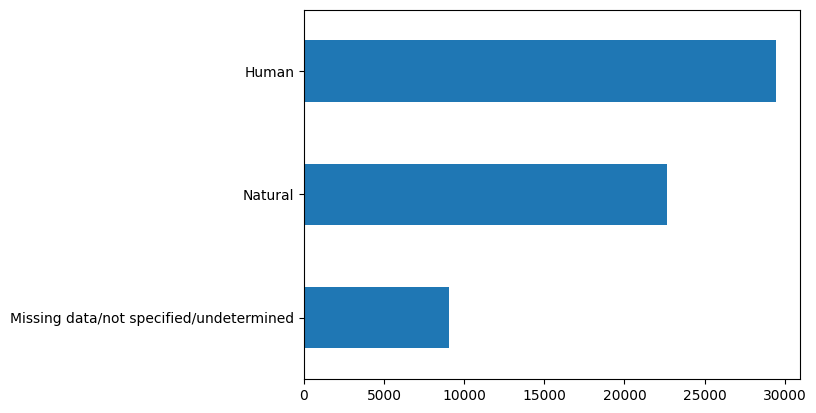

In [9]:
plot = df_co.NWCG_CAUSE_CLASSIFICATION.value_counts().sort_values().plot(kind='barh')
fig = plot.get_figure()
fig.savefig("output1.png")

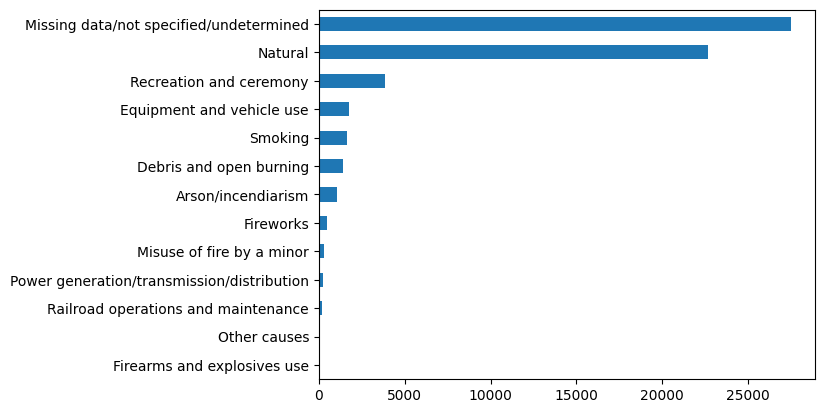

In [10]:
df_co.NWCG_GENERAL_CAUSE.value_counts().sort_values().plot(kind='barh')
fig = plot.get_figure()
fig.savefig("output2.png")

/var/folders/8x/96fv9lvs3ts4pvsg8w_06j4r0000gn/T/ipykernel_75601/3947333853.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plot = sns.heatmap(df_co.corr(),annot=True,cmap='viridis',linewidths=.5)


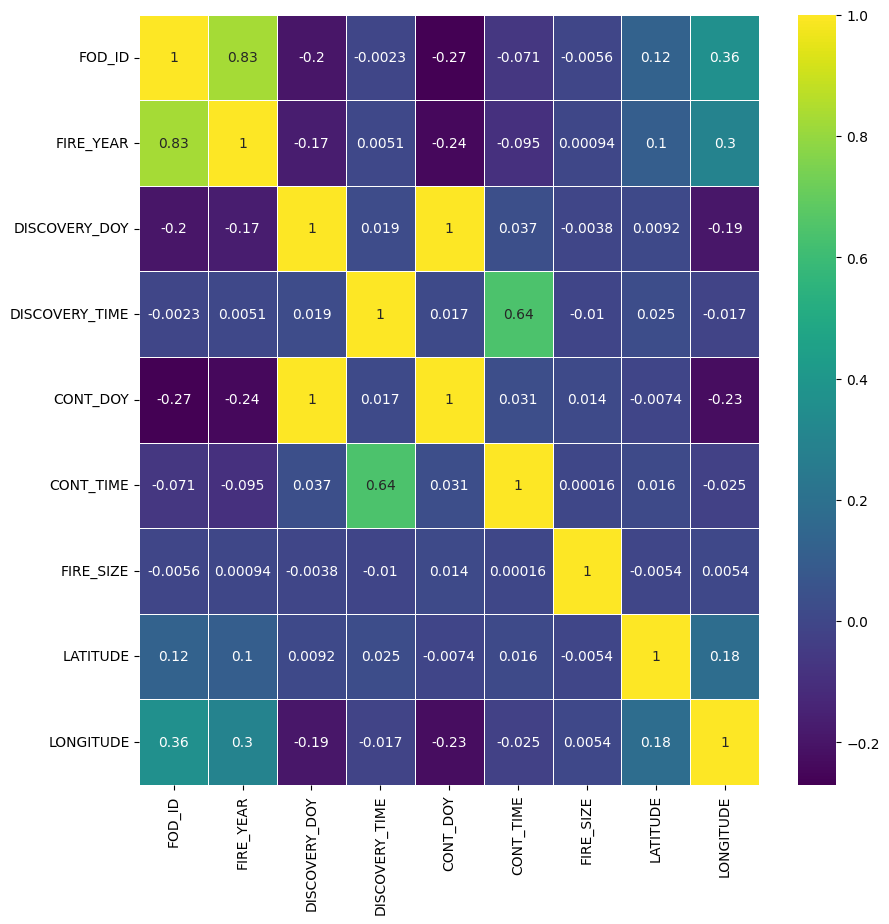

In [11]:
plt.figure(figsize=(10, 10))
plot = sns.heatmap(df_co.corr(),annot=True,cmap='viridis',linewidths=.5)
fig = plot.get_figure()
fig.savefig("output3.png")

/var/folders/8x/96fv9lvs3ts4pvsg8w_06j4r0000gn/T/ipykernel_75601/3349346790.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  _ = sns.heatmap(df_co.corr())


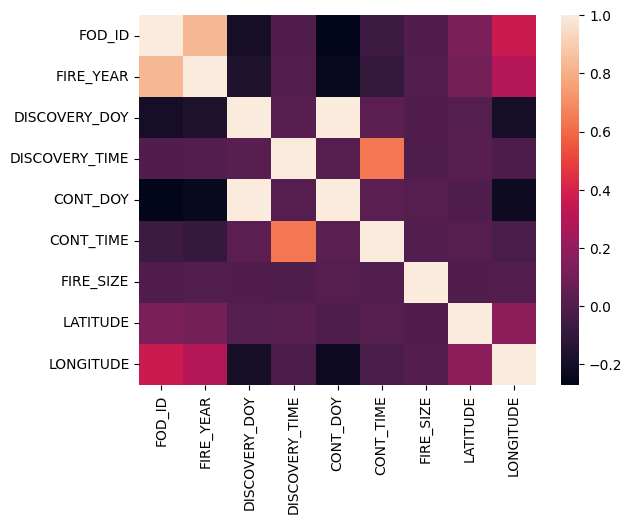

In [12]:
_ = sns.heatmap(df_co.corr())

Read in Weather Dataset

In [13]:
df_weather = pd.read_csv('3090639.csv')

In [14]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131269 entries, 0 to 131268
Data columns (total 45 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   STATION  131269 non-null  object 
 1   NAME     131269 non-null  object 
 2   DATE     131269 non-null  object 
 3   AWND     87071 non-null   float64
 4   DAWM     2 non-null       float64
 5   FMTM     36212 non-null   float64
 6   MDWM     2 non-null       float64
 7   PGTM     50957 non-null   float64
 8   PRCP     126477 non-null  float64
 9   TAVG     31231 non-null   float64
 10  TMAX     130897 non-null  float64
 11  TMIN     130888 non-null  float64
 12  TOBS     42475 non-null   float64
 13  WDF1     516 non-null     float64
 14  WDF2     79937 non-null   float64
 15  WDF5     79837 non-null   float64
 16  WDFG     3433 non-null    float64
 17  WDMV     1166 non-null    float64
 18  WSF1     516 non-null     float64
 19  WSF2     79937 non-null   float64
 20  WSF5     79882 non-null   

In [15]:
df_weather.drop(columns=['WT01','WT02','WT03','WT04','WT05','WT06','WT07','WT08','WT09','WT10','WT11',
                        'WT13','WT14','WT15','WT16','WT17','WT18','WT19','WT21','WT22','WV01','WT03',
                        'WV20', 'WSF1', 'MDWM', 'DAWM', 'TOBS', 'WV03'], axis=1, inplace=True)

In [16]:
df_weather = df_weather.fillna(0)

In [17]:
df_weather['DATE'] = pd.to_datetime(df_weather.DATE)

In [18]:
df_weather.head()

,STATION,NAME,DATE,AWND,FMTM,PGTM,PRCP,TAVG,TMAX,TMIN,WDF1,WDF2,WDF5,WDFG,WDMV,WSF2,WSF5,WSFG
0,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-01,0.0,0.0,0.0,0.0,0.0,89.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-02,0.0,0.0,0.0,0.0,0.0,81.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-03,0.0,0.0,0.0,0.0,0.0,85.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-04,0.0,0.0,0.0,0.0,0.0,88.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-05,0.0,0.0,0.0,0.0,0.0,86.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Correlate Lat/Long values between 

In [19]:
# Lat values
lat_vals = {
    'RIFLE GARFIELD CO AIRPORT, CO US': 39.5227,
    'CRAIG MOFFAT CO AIRPORT, CO US': 40.495556,
    'ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US': 39.2197, 
    'LIMON, CO US': 39.2639,
    'GEORGETOWN, CO US': 39.7061,
    'MONTROSE REGIONAL AIRPORT, CO US': 38.5002,
    'LEROY 5 WSW, CO US': 40.5261, 
    'CROOK, CO US': 40.8589,
    'GRAND LAKE 6 SSW, CO US': 40.2522,
    'MEEKER AIRPORT, CO US': 40.0407,
    'CORTEZ MONTEZUMA CO AIRPORT, CO US': 37.3044,
    'COLORADO SPRINGS MUNICIPAL AIRPORT, CO US': 38.8017,
    'DURANGO LA PLATA CO AIRPORT, CO US': 37.1597,
    'TRINIDAD AIRPORT, CO US': 37.1695,
    'LEADVILLE LAKE CO AIRPORT, CO US': 39.2239
}

long_vals = {
    'RIFLE GARFIELD CO AIRPORT, CO US': -107.7180,
    'CRAIG MOFFAT CO AIRPORT, CO US': -107.525,
    'ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US': -106.8646, 
    'LIMON, CO US': -103.6922,
    'GEORGETOWN, CO US': -105.6975,
    'MONTROSE REGIONAL AIRPORT, CO US': -107.8992,
    'LEROY 5 WSW, CO US': -102.9141, 
    'CROOK, CO US': -102.8010,
    'GRAND LAKE 6 SSW, CO US': -105.8231,
    'MEEKER AIRPORT, CO US': -107.8923,
    'CORTEZ MONTEZUMA CO AIRPORT, CO US': -108.6300,
    'COLORADO SPRINGS MUNICIPAL AIRPORT, CO US': -104.7026,
    'DURANGO LA PLATA CO AIRPORT, CO US': -107.7507,
    'TRINIDAD AIRPORT, CO US': -104.5005,
    'LEADVILLE LAKE CO AIRPORT, CO US': -106.3146
}     


ds = [lat_vals, long_vals]
stationLatLongs = {}
for k in lat_vals.keys():
  stationLatLongs[k] = tuple(stationLatLongs[k] for stationLatLongs in ds)

In [20]:
# Define functions for returning the lat/long for each weather site
# Note: Converting the Long to Negative to align with the wildfire data set

def get_lat(name):
    if name == 'RIFLE GARFIELD CO AIRPORT, CO US':
        return 39.5227
    elif name == 'CRAIG MOFFAT CO AIRPORT, CO US':
        return 40.495556
    elif name == 'ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US':
        return 39.2197
    elif name == 'LIMON, CO US':
        return 39.2639
    elif name == 'GEORGETOWN, CO US':
        return  39.7061
    elif name == 'MONTROSE REGIONAL AIRPORT, CO US':
        return 38.5002
    elif name == 'LEROY 5 WSW, CO US':
        return 40.5261
    elif name == 'CROOK, CO US':
        return 40.8589
    elif name == 'GRAND LAKE 6 SSW, CO US':
        return 40.2522
    elif name == 'MEEKER AIRPORT, CO US':
        return 40.0407
    elif name == 'CORTEZ MONTEZUMA CO AIRPORT, CO US':
        return 37.3044
    elif name == 'COLORADO SPRINGS MUNICIPAL AIRPORT, CO US':
        return 38.8017
    elif name == 'DURANGO LA PLATA CO AIRPORT, CO US':
        return 37.1597
    elif name == 'TRINIDAD AIRPORT, CO US':
        return 37.1695
    elif name == 'LEADVILLE LAKE CO AIRPORT, CO US':
        return 39.2239

def get_long(name):
    if name == 'RIFLE GARFIELD CO AIRPORT, CO US':
        return -107.7180
    elif name == 'CRAIG MOFFAT CO AIRPORT':
        return -107.525
    elif name == 'ASPEN PITKIN CO AIRPORT SARDY FIELD':
        return -106.8646
    elif name == 'LIMON, CO US':
        return -103.6922
    elif name == 'GEORGETOWN, CO US':
        return -105.6975
    elif name == 'MONTROSE REGIONAL AIRPORT, CO US':
        return -107.8992
    elif name == 'LEROY 5 WSW, CO US':
        return -102.9141
    elif name == 'CROOK, CO US':
        return -102.8010
    elif name == 'GRAND LAKE 6 SSW, CO US':
        return -105.8231
    elif name == 'MEEKER AIRPORT, CO US':
        return -107.8923
    elif name == 'CORTEZ MONTEZUMA CO AIRPORT, CO US':
        return -108.6300
    elif name == 'COLORADO SPRINGS MUNICIPAL AIRPORT, CO US':
        return -104.7026
    elif name == 'DURANGO LA PLATA CO AIRPORT, CO US':
        return -107.7507
    elif name == 'TRINIDAD AIRPORT, CO US':
        return -104.5005
    elif name == 'LEADVILLE LAKE CO AIRPORT, CO US':
        return -106.3146

In [21]:
df_weather['LAT'] = df_weather.apply(lambda row: get_lat(row.NAME), axis=1)
df_weather['LONG'] = df_weather.apply(lambda row: get_long(row.NAME), axis=1)

In [22]:
stationLatLongList = []
for val in stationLatLongs.values():
    entry = {'lat': val[0], 'long': val[1]}
    stationLatLongList.append(entry)

stationLatLongList

[{'lat': 39.5227, 'long': -107.718},
 {'lat': 40.495556, 'long': -107.525},
 {'lat': 39.2197, 'long': -106.8646},
 {'lat': 39.2639, 'long': -103.6922},
 {'lat': 39.7061, 'long': -105.6975},
 {'lat': 38.5002, 'long': -107.8992},
 {'lat': 40.5261, 'long': -102.9141},
 {'lat': 40.8589, 'long': -102.801},
 {'lat': 40.2522, 'long': -105.8231},
 {'lat': 40.0407, 'long': -107.8923},
 {'lat': 37.3044, 'long': -108.63},
 {'lat': 38.8017, 'long': -104.7026},
 {'lat': 37.1597, 'long': -107.7507},
 {'lat': 37.1695, 'long': -104.5005},
 {'lat': 39.2239, 'long': -106.3146}]

In [23]:
# Logic to find the distance between two lat/longs was sourced from StackOverflow: 
# https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

from math import cos, asin, sqrt

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(hav))

def closest(data, v):
    return min(data, key=lambda p: distance(v['lat'],v['long'],p['lat'],p['long']))

def get_nearest_station(lat, long):
    v = {'lat': lat, 'long': long}
    
    lat_key_list = list(lat_vals.keys())
    lat_value_list = list(lat_vals.values())
    
    nearestStationLatLong = closest(stationLatLongList, v)
    nearestStation = lat_key_list[lat_value_list.index(nearestStationLatLong['lat'])]
    return nearestStation


In [24]:
df_co['NEAREST_STATION'] = df_co.apply(lambda row: get_nearest_station(row.LATITUDE, row.LONGITUDE), axis=1)

In [25]:
for i, row in df_co.iterrows():
    df_weather.loc[((df_weather.DATE == row.DISCOVERY_DATE) & (df_weather.NAME == row.NEAREST_STATION)), 'FIRE'] = 1

In [26]:
df_weather['FIRE'] = df_weather['FIRE'].fillna(0)

/var/folders/8x/96fv9lvs3ts4pvsg8w_06j4r0000gn/T/ipykernel_75601/1157414070.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  weather_plot = sns.heatmap(df_weather.corr())


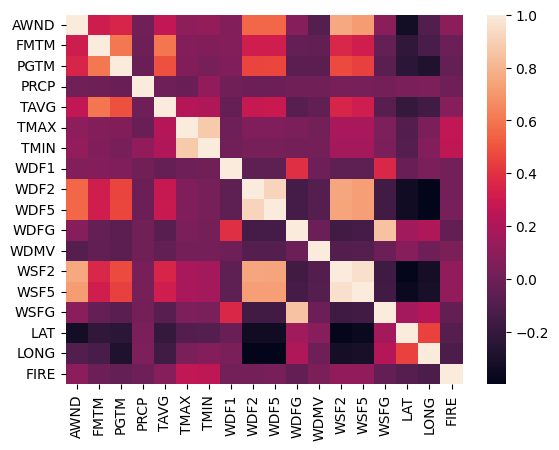

In [27]:
weather_plot = sns.heatmap(df_weather.corr())
fig = weather_plot.get_figure()
fig.savefig("output4.png", transparent=True)

In [28]:
df_co.head()

,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,NEAREST_STATION
47,48,2005,2005-06-14,165,1300.0,Natural,Natural,6/14/2005 0:00,165.0,1530.0,0.5,B,39.292222,-105.183056,"GEORGETOWN, CO US"
61,62,2005,2005-05-30,150,1100.0,Natural,Natural,5/31/2005 0:00,151.0,1218.0,0.2,A,38.913333,-105.983611,"LEADVILLE LAKE CO AIRPORT, CO US"
62,63,2005,2005-06-21,172,1241.0,Human,Recreation and ceremony,6/21/2005 0:00,172.0,1506.0,0.1,A,39.100278,-106.367500,"LEADVILLE LAKE CO AIRPORT, CO US"
114,117,2005,2005-07-07,188,1907.0,Natural,Natural,7/7/2005 0:00,188.0,2130.0,80.0,C,37.345000,-102.805833,"TRINIDAD AIRPORT, CO US"
205,209,2005,2005-06-13,164,1428.0,Human,Missing data/not specified/undetermined,6/13/2005 0:00,164.0,1736.0,2.5,B,38.891111,-105.431944,"COLORADO SPRINGS MUNICIPAL AIRPORT, CO US"


In [29]:
df_weather.head()

,STATION,NAME,DATE,AWND,FMTM,PGTM,PRCP,TAVG,TMAX,TMIN,...,WDF2,WDF5,WDFG,WDMV,WSF2,WSF5,WSFG,LAT,LONG,FIRE
0,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-01,0.0,0.0,0.0,0.0,0.0,89.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.5227,-107.718,0.0
1,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-02,0.0,0.0,0.0,0.0,0.0,81.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.5227,-107.718,0.0
2,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-03,0.0,0.0,0.0,0.0,0.0,85.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.5227,-107.718,0.0
3,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-04,0.0,0.0,0.0,0.0,0.0,88.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.5227,-107.718,0.0
4,USW00003016,"RIFLE GARFIELD CO AIRPORT, CO US",1997-06-05,0.0,0.0,0.0,0.0,0.0,86.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.5227,-107.718,0.0


In [30]:
df_weather.columns

Index(['STATION', 'NAME', 'DATE', 'AWND', 'FMTM', 'PGTM', 'PRCP', 'TAVG',
       'TMAX', 'TMIN', 'WDF1', 'WDF2', 'WDF5', 'WDFG', 'WDMV', 'WSF2', 'WSF5',
       'WSFG', 'LAT', 'LONG', 'FIRE'],
      dtype='object')

Logistic Regression Model

In [31]:
# Split weather dataset into features and target variable 

weather_cols = ['AWND', 'FMTM', 'PGTM', 'PRCP','TAVG','TMAX','TMIN', 'WDF1', 'WDF2', 'WDF5', 'WDFG', 'WDMV', 'WSF2', 
             'WSF5', 'WSFG'] 

x = df_weather[weather_cols] 

y = df_weather.FIRE

In [32]:
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0) 

In [33]:
# Create Logistic Regression model
lr_model =  LogisticRegression(solver='liblinear') 

# Fit the LR model with data 
lr_model.fit(x_train,y_train) 

# Create predictions
y_pred=lr_model.predict(x_test) 
y_pred 

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix

array([[26035,   301],
       [ 6056,   426]])

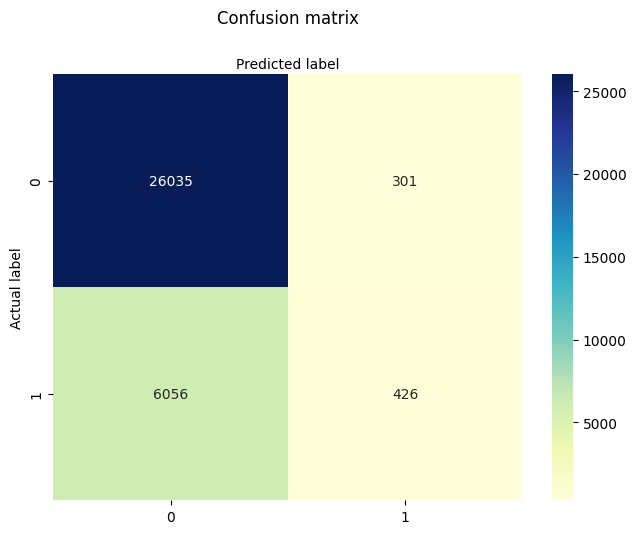

In [35]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

plt.savefig("output5.png", transparent=True)

In [36]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

print("Precision:",metrics.precision_score(y_test, y_pred)) 

print("Recall:",metrics.recall_score(y_test, y_pred)) 

Accuracy: 0.8062953257358767
Precision: 0.5859697386519945
Recall: 0.06572045664918236


Random Forest

In [37]:
# creating a RF classifier
rfClass = RandomForestClassifier(n_estimators = 100) 
 
# Fit model
rfClass.fit(x_train, y_train)
 
# Perform Predictions
y_pred = rfClass.predict(x_test)

In [38]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred)) 

print("Precision: ", metrics.precision_score(y_test, y_pred)) 

print("Recall: ", metrics.recall_score(y_test, y_pred)) 

Accuracy:  0.813852154305564
Precision:  0.5701919458035378
Recall:  0.23372415921012032


In [39]:
feature_imp = pd.Series(rfClass.feature_importances_, index = weather_cols).sort_values(ascending = False)
feature_imp

TMAX    0.181868
TMIN    0.172939
AWND    0.114124
WSF5    0.073705
WDF2    0.072055
WDF5    0.071062
PRCP    0.068254
WSF2    0.065059
PGTM    0.062649
TAVG    0.052858
FMTM    0.045441
WDMV    0.009153
WSFG    0.005546
WDFG    0.004193
WDF1    0.001093
dtype: float64

In [40]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix

array([[25194,  1142],
       [ 4967,  1515]])

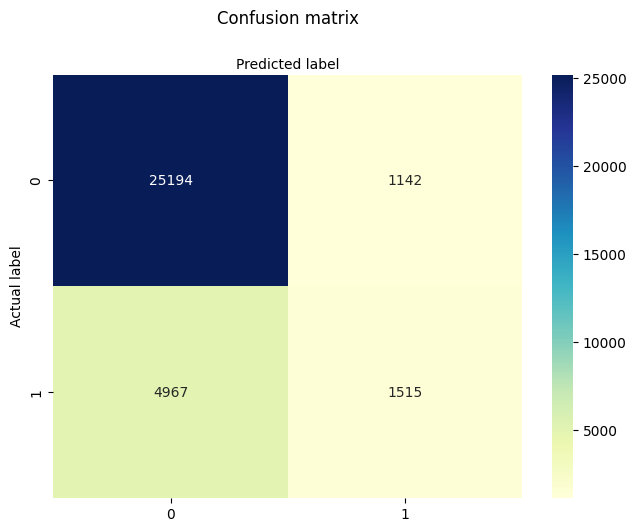

In [41]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

plt.savefig("output6.png", transparent=True)